# Lab 4 - Information Processing and Retrieval

## Document organizing, annotation, ranking

In [2]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'rec.autos', 'sci.crypt', 'talk.politics.guns']
collection = fetch_20newsgroups(subset='test', categories=categories)

In [3]:
for i in range(2):
    print(collection.data[i])
    print(collection.target[i])
    print(collection.target_names[collection.target[i]])
    print()

From: holland@CS.ColoState.EDU (douglas craig holland)
Subject: What would happen if export restrictions violated?
Nntp-Posting-Host: beethoven.cs.colostate.edu
Organization: Colorado State University, Computer Science Department
Lines: 15


OK, I heard a lot of talk about the NSA's infamous control over encryption
export through the ITAR.  Here's a question.  Say I develop this great new
encryption system, and I want to sell my software worldwide.  The thought
police then come in and say "This algorithm is a threat to national security.
You will not be permitted to export it."  At this point, what kind of trouble
could I get into if I ignored the ITAR and sold my program to international
customers anyway?

Doug Holland

-- 
|  Doug Holland                | Anyone who tries to take away my freedom  |
|  holland@cs.colostate.edu    | of speech will have to pry it from my     |
|  PGP key available by E-mail | cold, dead lips!!                         |

2
sci.crypt

From: strnlght@netco

Since data is in a text format, we need to process it in order to extract useful information. Let's use TFIDF from scikit-learn

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=False)

X = vectorizer.fit_transform(collection.data)

In [5]:
print(X.shape)

(1545, 26904)


In [6]:
print(vectorizer.get_feature_names_out())

['00' '000' '0000' ... 'zyda' 'zyeh' 'zyxel']


# 1 Cluster the collection

1.1. Extract the vector space of the 20 Newsgroup (use collection.data instruction to ignore
the class variable), and cluster the collection using agglomerative clustering from scikit-learn

In [7]:
from sklearn.cluster import AgglomerativeClustering



clustering = AgglomerativeClustering().fit(X.toarray())

# Note: we convert X to an array because it's needed by AgglomerativeClustering


In [8]:
print(clustering.labels_)

[0 0 0 ... 0 1 0]


In [9]:
# Print all distinct labels
print(set(clustering.labels_))

{0, 1}


Try to parameterize the number of clusters and the linkage method. 

In [10]:

n_clusters = len(categories)
# choose the best number for n_clusters
single = AgglomerativeClustering(linkage='single', n_clusters=n_clusters, metric='cosine').fit(X.toarray())
complete = AgglomerativeClustering(linkage='complete', n_clusters=n_clusters, metric='cosine').fit(X.toarray())

In [11]:
single_labels = single.labels_
complete_labels = complete.labels_

In [12]:
print(single_labels)
print(complete_labels)

[0 0 0 ... 0 0 0]
[1 3 1 ... 3 1 3]


1.2. Plot the learned dendogram using the cluster.hierarchy.dendrogram package from scipy.
Compare the clustering solutions produced under single and complete linkage criteria.

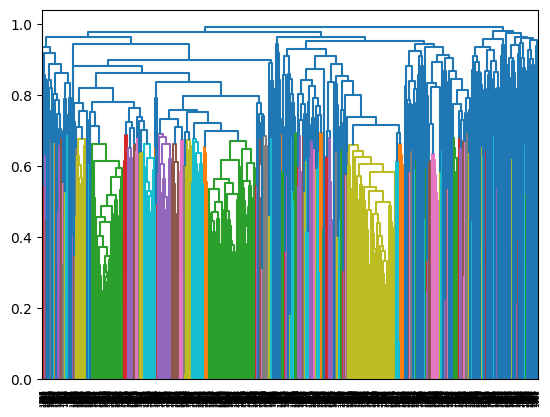

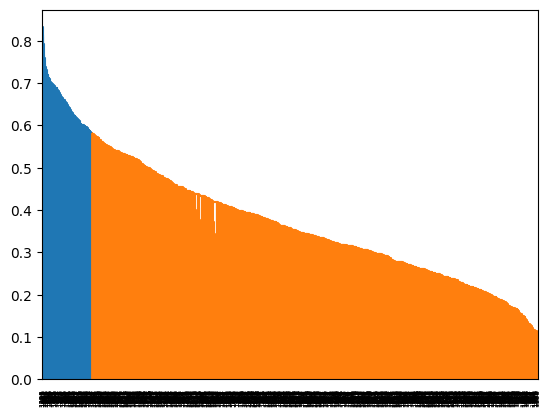

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(X.toarray(), method='complete', metric='cosine')

plt.figure()
dendrogram(Z)
plt.show()

Z = linkage(X.toarray(), method='single', metric='cosine')

plt.figure()
dendrogram(Z)
plt.show()



1.3. Evaluate the clustering solution by computing an internal measure (e.g. silhouette) and an
external measure (e.g. adjusted rand index) for the produced clustering solution.

In [14]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
sscore = silhouette_score(X, single_labels, metric='cosine')
cscore = silhouette_score(X, complete_labels, metric='cosine')

# for the random score we need the true labels
true_labels = collection.target

arsingle = adjusted_rand_score(true_labels, single_labels)
arcomplete = adjusted_rand_score(true_labels, complete_labels)

print(f"Silhouette score for single linkage: {sscore}")
print(f"Silhouette score for complete linkage: {cscore}")
print(f"Adjustewd Rand score for single linkage: {arsingle}")
print(f"Adjusted Rand score for complete linkage: {arcomplete}")


Silhouette score for single linkage: 0.26392018268553363
Silhouette score for complete linkage: 0.02735054639193526
Adjustewd Rand score for single linkage: -3.059877070379207e-05
Adjusted Rand score for complete linkage: 0.015177362174200237


1.4. (homework) Principal component analysis (PCA), latent semantic indexing (LSI) and uMAP
procedures offer a way of projecting our high-dimensional vector space into a space with lower
dimensionality. Map the original space into a 2-dimensional space, plotting the documents in
this new space. Color the documents according to their cluster to assess their separation

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
new_X = pca.fit_transform(X.toarray())

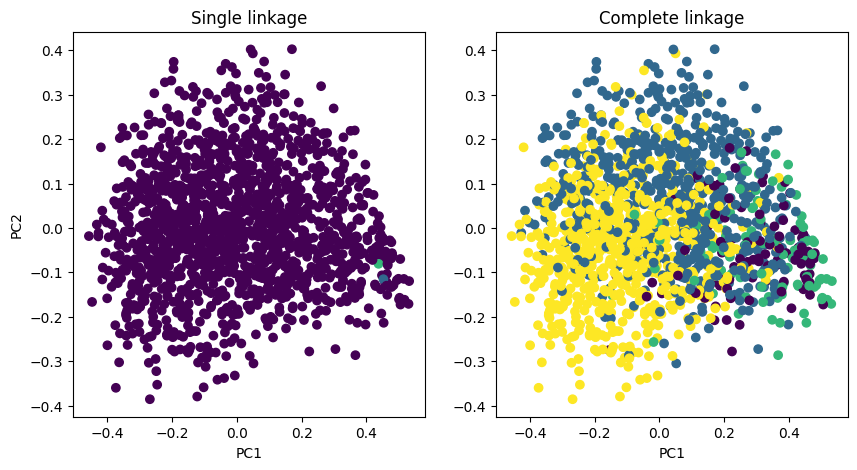

In [16]:
plt.figure(figsize=(10, 5))

# Plotting PCA
plt.subplot(1, 2, 1)
plt.scatter(new_X[:, 0], new_X[:, 1], c=single_labels, cmap='viridis')
plt.title('Single linkage')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 2, 2)
plt.scatter(new_X[:, 0], new_X[:, 1], c=complete_labels, cmap='viridis')
plt.title('Complete linkage')
plt.xlabel('PC1')

plt.show()

### 2 Document classification in the 20 NewsGroup

In [17]:
# Split the 20news dataset into training and testing sets

from sklearn.datasets import fetch_20newsgroups
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

In [18]:
# Vect
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=False)
trainvec = vectorizer.fit_transform(train.data)
testvec = vectorizer.transform(test.data)

In [19]:
# Print the label numeric and the label name
print(train.target[0])
print(train.target_names[train.target[0]])


7
rec.autos


In [20]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
classifier = MultinomialNB()
classifier.fit(trainvec, train.target)

classes = classifier.predict(testvec)

In [21]:
# Evaluation
from sklearn import metrics

print(metrics.accuracy_score(test.target, classes))
print(metrics.classification_report(test.target, classes, target_names=test.target_names))

0.7052575677110993
                          precision    recall  f1-score   support

             alt.atheism       0.85      0.24      0.37       319
           comp.graphics       0.71      0.60      0.65       389
 comp.os.ms-windows.misc       0.79      0.65      0.71       394
comp.sys.ibm.pc.hardware       0.63      0.75      0.69       392
   comp.sys.mac.hardware       0.86      0.68      0.76       385
          comp.windows.x       0.88      0.68      0.77       395
            misc.forsale       0.90      0.72      0.80       390
               rec.autos       0.71      0.92      0.80       396
         rec.motorcycles       0.84      0.91      0.87       398
      rec.sport.baseball       0.86      0.85      0.86       397
        rec.sport.hockey       0.90      0.93      0.91       399
               sci.crypt       0.52      0.96      0.67       396
         sci.electronics       0.78      0.52      0.63       393
                 sci.med       0.82      0.76      0.79 

2.2. Try to improve the classification by:
(a) Removing very rare words (e.g. words that occur less than 2 times) or very frequent words
(e.g. words that occur in more than 90% documents) using Vectorizer utils by scikit-learn

In [22]:
# Remove very rare words usign Vectorizer utils

maxes = [80,85,90,95]
mines = [2,5,10,20]

bestmax = 0
bestmin = 0

bestscore = 0

for max in maxes:
    for min in mines:
        vectorizer = TfidfVectorizer(use_idf=False, max_df=max, min_df=min)
        trainvec = vectorizer.fit_transform(train.data)
        testvec = vectorizer.transform(test.data)
        classifier = MultinomialNB()
        classifier.fit(trainvec, train.target)
        classes = classifier.predict(testvec)
        score = metrics.accuracy_score(test.target, classes)
        if score > bestscore:
            bestscore = score
            bestmax = max
            bestmin = min

print(f"Best score: {bestscore}")
print(f"Best max: {bestmax}")
print(f"Best min: {bestmin}")






Best score: 0.7731014338821031
Best max: 90
Best min: 2


In [23]:
# Compare with KNN, perceptron and svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

# Keep the best vectorizer

vectorizer = TfidfVectorizer(use_idf=False, max_df=90, min_df=2)

scores = {}

trainvec = vectorizer.fit_transform(train.data)
testvec = vectorizer.transform(test.data)

# KNN
knn = KNeighborsClassifier()
knn.fit(trainvec, train.target)
classes = knn.predict(testvec)
scores['KNN'] = metrics.accuracy_score(test.target, classes)

# Perceptron
perceptron = Perceptron()
perceptron.fit(trainvec, train.target)
classes = perceptron.predict(testvec)
scores['Perceptron'] = metrics.accuracy_score(test.target, classes)

# SVM
svm = SVC()
svm.fit(trainvec, train.target)
classes = svm.predict(testvec)
scores['SVM'] = metrics.accuracy_score(test.target, classes)



In [24]:
scores['Naive Bayes'] = bestscore
print(scores)

{'KNN': 0.602761550716941, 'Perceptron': 0.7267657992565055, 'SVM': 0.7320764737121614, 'Naive Bayes': 0.7731014338821031}


3 Learning to Rank
Let us create a ranking method that linearly combines results from different scoring functions

score(q, d) = α1bm25(q, d) + α2cos(q, d) + α3f req(q, d)

where d is the document, q is the query, bm25 is the score obtained using the BM25 ranking
function, cos is the score obtained using the TF IDF ranking function, and f req is the score
obtained using the Term Frequency ranking function.

In [25]:

def bm25(q,d):
    k = 1.2
    b = 0.75
    score = 0
    for term in q:
        if term in d:
            idf = 1
            tf = 1
            score += (idf * tf * (k + 1)) / (tf + k * (1 - b + b * len(d) / 100))
    return score

# TF_IDF Ranking function
def tfidf(q,d, useidf=True):
    text = [''.join(q), ''.join(d)]

    vectorizer = TfidfVectorizer(use_idf=useidf)

    tfidfvals = vectorizer.fit_transform(text)

    features = vectorizer.get_feature_names_out()

    dvec = tfidfvals.toarray()[1]

    score = 0
    for term in q:
        if term in features:
            index = list(features).index(term)
            score+=dvec[index]

    return score

def score(q,d):
    bm25score = bm25(q,d)
    tfidfscore = tfidf(q,d)
    tfscore = tfidf(q,d, False)

    alpha1 = 0.5
    alpha2 = 0.3
    alpha3 = 0.2

    score = alpha1 * bm25score + alpha2 * tfidfscore + alpha3 * tfscore

    return score
    
    

In [28]:
# get files path
import os

files = []

for root, dirs, file in os.walk('../Lab4'):
    for f in file:
        # check if txt
        if f.endswith('.txt'):
            files.append(os.path.join(root, f))


docs = []

with open(files[0], 'r') as f:
    # split on space only 1 time
    # while still lines
    lines = f.readlines()
    doc = ''
    for line in lines:
        doc += line.split(' ', 1)[1]
        docs.append(doc)
        doc = ''

docs


['The significance of Pseudomonas aeruginosa infection in the respiratory tract of 9 cystic fibrosis patients have been studied by means of immunoelectrophoretical analysis of patients\' sera for the number of precipitins against Pseudomonas aeruginosa and the concentrations of 16 serum proteins.  In addition, the clinical and radiographical status of the lungs have been evaluated using 2 scoring systems.  Precipitins against Pseudomonas aeruginosa were demonstrated in all sera, the maximum number in one serum was 22. The concentrations of 12 of the serum proteins were significantly changed compared with matched control persons.  Notably IgG and IgA were elevated and the "acute phase proteins" were changed, the latter suggesting active tissue damage.  The concentrations of 3 of the acute phase proteins, notably haptoglobin, were correlated to the number of precipitins suggesting that the respiratory tract infection in patients with many precipitins is accompanied by more tissue damage 

In [33]:
queries = []

with open(files[1], 'r') as f:
    lines = f.readlines()
    query = ''
    count = 0
    for line in lines:
        # read 2 lines and append
        query+=line+' '
        count+=1
        if count == 2:
            queries.append(query.strip())
            query = ''
            count = 0
    
        
queries  

['What are the effects of calcium on the physical properties of mucus from CF patients? \n 139 151 166 311 370 392 439 440 441 454 461 502 503 505 520 522 526 527 533 593 619 737 742 789 827 835 861 875 891 921 922 1175 1185 1222',
 'Can one distinguish between the effects of mucus hypersecretion and infection on the submucosal glands of the respiratory tract in CF?\n 169 434 454 498 499 592 875',
 'How are salivary glycoproteins from CF patients different from those of normal subjects?\n 23 40 139 190 221 246 309 311 325 345 347 356 370 374 375 439 440 454 515 520 524 526 527 533 535 560 561 571 584 604 623 633 733 742 854 856 950 967 1144 1161 1172 1175 1196',
 'What is the lipid composition of CF respiratory secretions?\n 503 538 539 540 553 604 669 711 876',
 'Is CF mucus abnormal?\n 23 47 50 60 114 132 135 139 151 169 189 190 197 200 226 256 265 297 298 299 311 312 325 333 343 347 349 369 370 371 374 386 392 410 420 427 428 430 434 437 439 440 441 450 461 465 478 496 497 498 499 5

In [36]:
# get the scores
query = queries[0].split('\n')[0]
print(query)
scores = []
for doc in docs:
    scores.append(score(query, doc))

print(scores)

What are the effects of calcium on the physical properties of mucus from CF patients? 
[7.712697734074398, 9.632635625800939, 10.557586837294338, 8.545269582909471, 10.853086271206845, 6.955660521103163, 5.8662851196670145, 4.955499395670805, 20.310740824138733, 24.83677910772575, 10.439498361767026, 13.08210345321681, 15.825998645903827, 4.280358752906565, 14.794161062817766, 17.81904385618333, 13.149935186518823, 5.719354049425014, 5.64274809160306, 15.90635221208472, 16.04005621925511, 9.958048134245972, 8.067509057170618, 6.702885250715811, 18.44203639337559, 13.076253986662817, 14.186851211072689, 21.349112426035532, 14.816031537450714, 8.318906605922564, 8.531068230080336, 19.110169491525387, 13.087818696883852, 8.91862850444467, 21.33676092544989, 7.0588235294117565, 9.712765957446816, 14.222695466991194, 12.787199124726488, 11.694633021647226, 12.427666023698007, 23.501823866597196, 5.9953283155982255, 22.858590978205786, 13.464090842058683, 6.829711516619981, 7.322158954206438

3.2. Let us try a more sophisticated approach to combine the functions by training a Logistic
Regression classifier2 on the set of queries in pri queries.txt from the second lab.

More specifically:
(a) Create a dataset for training and testing your Learning to Rank (L2R) approach:
• use 70% of the queries for training and 30% for testing;
• with the training queries, build the training dataset. This dataset should contain, for
each (query q, document d) pair, a set of instances {x1, .., xn} with the format:
xi = (bm25(q, d), cos(q, d), f req(q, d), r)
where r = 1 if document d is relevant for query q and r = 0 otherwise;


• use the same number of relevant and non-relevant documents for each query.


(b) Use the training data to learn the logistic regression classifier with relevance r as target.


(c) Run one testing query using the learnt logistic regression as your classifier (1 if the do-
cument is relevant or 0 if otherwise). Compute the precision, recall, and F1 scores against
ground relevance.


(d) Run one testing query using the learnt logistic regression as your ranking function. To
order the resulting documents, use the probability of the document being relevant through
the predict proba method.

 Compute the MAP for the produced ranking

In [41]:
# Lets do 70 30 for train and test for the quries

train = queries[:int(len(queries)*0.7)]
test = queries[int(len(queries)*0.7):]

In [55]:
scores = []

for q in train:
    rel_docs = q.split("\n")[1].split(" ")[1:]
    # cast to int
    rel_docs = [int(i) for i in rel_docs]

    print(rel_docs)

    number_docs = len(q.split("\n")[1].split(" "))

    count = [0, 0]

    for index, doc in enumerate(docs):
        if count[0] == number_docs and count[1] == number_docs:
            break

        bm25score = bm25(q, doc)
        tfidfscore = tfidf(q, doc)
        tfscore = tfidf(q, doc, False)

        if index in rel_docs and count[1] < number_docs:
            # rel
            count[1] += 1
            label = 1
            bm25score = bm25(q, doc)
            tfidfscore = tfidf(q, doc)
            tfscore = tfidf(q, doc, False)
        elif index not in rel_docs and count[0] < number_docs:
            # non rel
            count[0] += 1
            label = 0
            bm25score = bm25(q, doc)
            tfidfscore = tfidf(q, doc)
            tfscore = tfidf(q, doc, False)

        scores.append([bm25score, tfidfscore, tfscore, label])

print(scores)


[139, 151, 166, 311, 370, 392, 439, 440, 441, 454, 461, 502, 503, 505, 520, 522, 526, 527, 533, 593, 619, 737, 742, 789, 827, 835, 861, 875, 891, 921, 922, 1175, 1185, 1222]
[169, 434, 454, 498, 499, 592, 875]
[23, 40, 139, 190, 221, 246, 309, 311, 325, 345, 347, 356, 370, 374, 375, 439, 440, 454, 515, 520, 524, 526, 527, 533, 535, 560, 561, 571, 584, 604, 623, 633, 733, 742, 854, 856, 950, 967, 1144, 1161, 1172, 1175, 1196]
[503, 538, 539, 540, 553, 604, 669, 711, 876]
[23, 47, 50, 60, 114, 132, 135, 139, 151, 169, 189, 190, 197, 200, 226, 256, 265, 297, 298, 299, 311, 312, 325, 333, 343, 347, 349, 369, 370, 371, 374, 386, 392, 410, 420, 427, 428, 430, 434, 437, 439, 440, 441, 450, 461, 465, 478, 496, 497, 498, 499, 500, 501, 502, 503, 505, 511, 513, 516, 520, 524, 531, 533, 549, 553, 559, 561, 568, 590, 592, 593, 604, 605, 633, 669, 701, 702, 710, 711, 722, 724, 729, 731, 733, 750, 761, 763, 772, 779, 788, 805, 843, 845, 856, 857, 861, 864, 867, 875, 876, 888, 889, 895, 925, 935, 943

KeyboardInterrupt: 